In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Bidirectional
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
# Load the dataset

df = pd.read_csv('/content/T1.csv')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50530 non-null  object 
 1   LV ActivePower (kW)            50530 non-null  float64
 2   Wind Speed (m/s)               50530 non-null  float64
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 4   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


In [2]:
df = df[df['LV ActivePower (kW)'] >= 0]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50473 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50473 non-null  object 
 1   LV ActivePower (kW)            50473 non-null  float64
 2   Wind Speed (m/s)               50473 non-null  float64
 3   Theoretical_Power_Curve (KWh)  50473 non-null  float64
 4   Wind Direction (°)             50473 non-null  float64
dtypes: float64(4), object(1)
memory usage: 2.3+ MB


In [3]:
# Step 1: Separate Date and Time using str.extract()
df[['Date', 'Time']] = df['Date/Time'].str.extract(r'(\d{2} \d{2} \d{4})\s+(\d{2}:\d{2})')
df['Date'] = pd.to_datetime(df['Date'], format='%d %m %Y')
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M').dt.hour

# Extract additional features
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month

adding  min also


In [4]:
# Step 1: Separate Date and Time using str.extract()
df[['Date', 'Time']] = df['Date/Time'].str.extract(r'(\d{2} \d{2} \d{4})\s+(\d{2}:\d{2})')
df['Date'] = pd.to_datetime(df['Date'], format='%d %m %Y')

# Extract Hour and Minute
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M').dt.hour
df['Minute'] = pd.to_datetime(df['Time'], format='%H:%M').dt.minute  # Extract minutes

# Extract additional features
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month


In [5]:
df.tail()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Date,Time,Hour,Day,Month,Minute
50525,31 12 2018 23:10,2963.980957,11.404030,3397.190793,80.502724,2018-12-31,23:10,23,31,12,10
50526,31 12 2018 23:20,1684.353027,7.332648,1173.055771,84.062599,2018-12-31,23:20,23,31,12,20
50527,31 12 2018 23:30,2201.106934,8.435358,1788.284755,84.742500,2018-12-31,23:30,23,31,12,30
50528,31 12 2018 23:40,2515.694092,9.421366,2418.382503,84.297913,2018-12-31,23:40,23,31,12,40
50529,31 12 2018 23:50,2820.466064,9.979332,2779.184096,82.274620,2018-12-31,23:50,23,31,12,50


In [6]:
# Step 2: Normalize Data
scaler = MinMaxScaler()
df[['Wind Speed (m/s)', 'LV ActivePower (kW)', 'Hour',"Minute", 'Day', 'Month','Theoretical_Power_Curve (KWh)']] = scaler.fit_transform(
    df[['Wind Speed (m/s)', 'LV ActivePower (kW)', 'Hour',"Minute", 'Day', 'Month','Theoretical_Power_Curve (KWh)']]
)



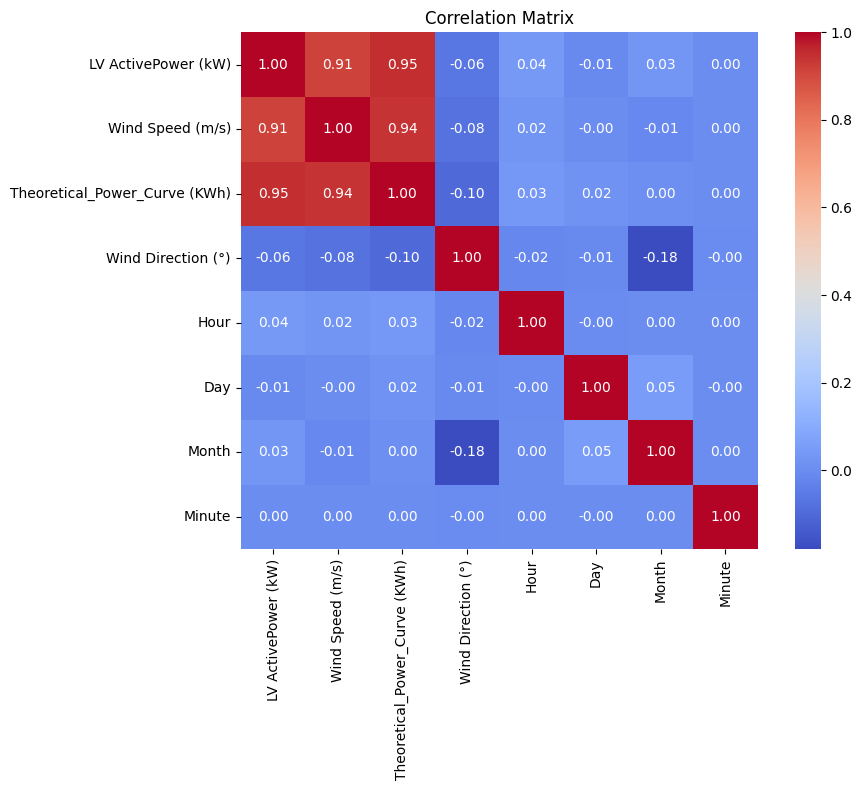

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df
# Drop non-numeric/object columns if needed
df_numeric = df.select_dtypes(include=['float64', 'int64'])

# Compute correlation matrix
corr_matrix = df_numeric.corr()

# Plot it using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


In [8]:
df.iloc[10000:10010]

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),Date,Time,Hour,Day,Month,Minute
10026,16 03 2018 03:00,0.324746,0.300133,0.358802,203.354004,2018-03-16,03:00,0.130435,0.5,0.181818,0.0
10027,16 03 2018 03:10,0.324350,0.296867,0.346968,205.664001,2018-03-16,03:10,0.130435,0.5,0.181818,0.2
10028,16 03 2018 03:20,0.380471,0.318885,0.431034,204.723099,2018-03-16,03:20,0.130435,0.5,0.181818,0.4
10029,16 03 2018 03:30,0.416292,0.332844,0.489001,202.124603,2018-03-16,03:30,0.130435,0.5,0.181818,0.6
10030,16 03 2018 03:40,0.498196,0.355297,0.587615,201.963303,2018-03-16,03:40,0.130435,0.5,0.181818,0.8
10031,16 03 2018 03:50,0.582137,0.374315,0.674257,202.633804,2018-03-16,03:50,0.130435,0.5,0.181818,1.0
10032,16 03 2018 04:00,0.613827,0.386628,0.728702,201.845306,2018-03-16,04:00,0.173913,0.5,0.181818,0.0
10033,16 03 2018 04:10,0.685086,0.407811,0.820523,201.372498,2018-03-16,04:10,0.173913,0.5,0.181818,0.2
10034,16 03 2018 04:20,0.706150,0.412406,0.837301,202.428696,2018-03-16,04:20,0.173913,0.5,0.181818,0.4
10035,16 03 2018 04:30,0.752914,0.417998,0.856336,202.129303,2018-03-16,04:30,0.173913,0.5,0.181818,0.6


In [10]:
# Step 3: Prepare Sequences
def create_sequences(data, target_column_index, lookback=15):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, :])
        y.append(data[i, target_column_index])
    return np.array(X), np.array(y)
feature_data = df[['Hour',"Minute", 'Day', 'Month', 'Theoretical_Power_Curve (KWh)', 'Wind Speed (m/s)', 'LV ActivePower (kW)']].values
# feature_data = df[[ 'Theoretical_Power_Curve (KWh)', 'Wind Speed (m/s)', 'LV ActivePower (kW)']].values

X, y = create_sequences(feature_data, target_column_index=6)


for next 5 hours

In [ ]:
# def create_sequences(data, target_column_index, lookback=10, future_steps=5):
#     X, y = [], []
#     for i in range(lookback, len(data) - future_steps):
#         X.append(data[i - lookback:i, :])  # Past `lookback` steps
#         y.append(data[i + future_steps, target_column_index])  # Future value
#     return np.array(X), np.array(y)

# # feature_data = df[['Theoretical_Power_Curve (KWh)','Wind Speed (m/s)', 'Hour', 'Day', 'Month', 'LV ActivePower (kW)']].values
# feature_data = df[['Hour',"Minute", 'Day', 'Month', 'Theoretical_Power_Curve (KWh)', 'Wind Speed (m/s)', 'LV ActivePower (kW)']].values

# X, y = create_sequences(feature_data, target_column_index=6)


In [ ]:
print(X.shape)

(50458, 10, 7)


In [11]:
# Step 4: Split into Training and Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# # Step 5: Build LSTM Model
# model = Sequential()
# model.add(LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
# model.add(LSTM(32, return_sequences=False))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')

# # Step 6: Train the Model
# history =model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


632/632 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step - loss: 0.0241 - val_loss: 0.0057
Epoch 2/30
632/632 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 3/30
632/632 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0049 - val_loss: 0.0043
Epoch 4/30
632/632 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 5/30
632/632 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 6/30
632/632 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 7/30
632/632 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 8/30
632/632 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 9/30
632/632 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 10/30
632/632 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 11/30
632/632 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 12/30
632/632 ━━━━━━━━━━━━━━━━━━━━ 

In [12]:
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X.shape[1], X.shape[2])))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32, return_sequences=False)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Step 6: Train the Model
history =model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - loss: 0.0138 - val_loss: 0.0062
Epoch 2/20
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - loss: 0.0054 - val_loss: 0.0050
Epoch 3/20
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 29s 22ms/step - loss: 0.0049 - val_loss: 0.0050
Epoch 4/20
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - loss: 0.0045 - val_loss: 0.0050
Epoch 5/20
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.0046 - val_loss: 0.0053
Epoch 6/20
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 7/20
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 8/20
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 9/20
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.0045 - val_loss: 0.0046
Epoch 10/20
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 0.0045 - val_loss: 0.0047
Epoch 11/20
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.0044 - val_loss: 0.0046
Epoch 12

In [ ]:
# model = Sequential()

# # 1D CNN layer
# model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(X.shape[1], X.shape[2])))

# # LSTM layers
# model.add(Bidirectional(LSTM(128, return_sequences=True)))
# model.add(Bidirectional(LSTM(64, return_sequences=True)))
# model.add(Bidirectional(LSTM(64, return_sequences=True)))
# model.add(Bidirectional(LSTM(32, return_sequences=False)))

# # Dense layers
# model.add(Dense(64, activation='relu'))
# model.add(Dense(1))

# # Compile the model
# model.compile(optimizer='adam', loss='mse')
# # Step 6: Train the Model
# history =model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 29s 20ms/step - loss: 0.0143 - val_loss: 0.0049
Epoch 2/20
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 41s 20ms/step - loss: 0.0050 - val_loss: 0.0052
Epoch 3/20
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 39s 18ms/step - loss: 0.0051 - val_loss: 0.0056
Epoch 4/20
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.0050 - val_loss: 0.0051
Epoch 5/20
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 6/20
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.0048 - val_loss: 0.0046
Epoch 7/20
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 42s 21ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 8/20
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 39s 19ms/step - loss: 0.0050 - val_loss: 0.0047
Epoch 9/20
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.0047 - val_loss: 0.0048
Epoch 10/20
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 11/20
1104/1104 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - loss: 0.0046 - val_loss: 0.0047
Epoch 12

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


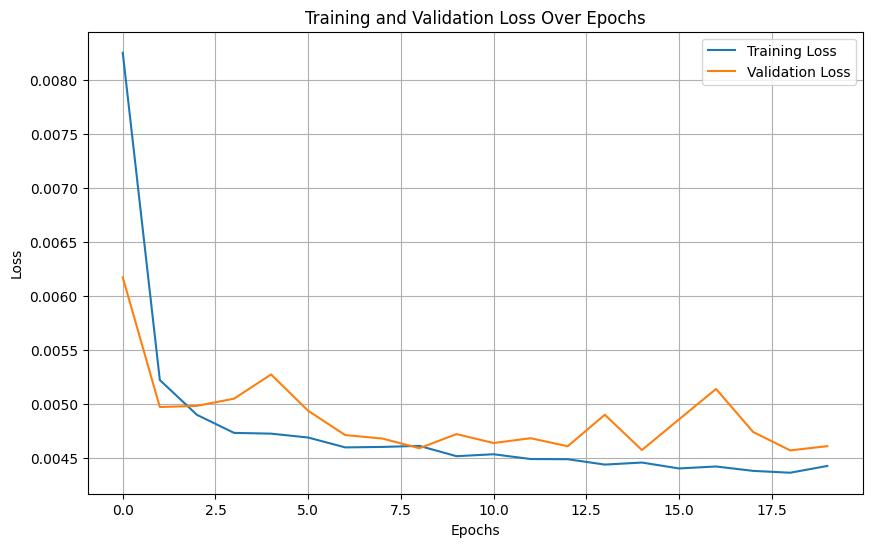

In [13]:
# Step 8: Plot Training and Validation Loss
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

1577/1577 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


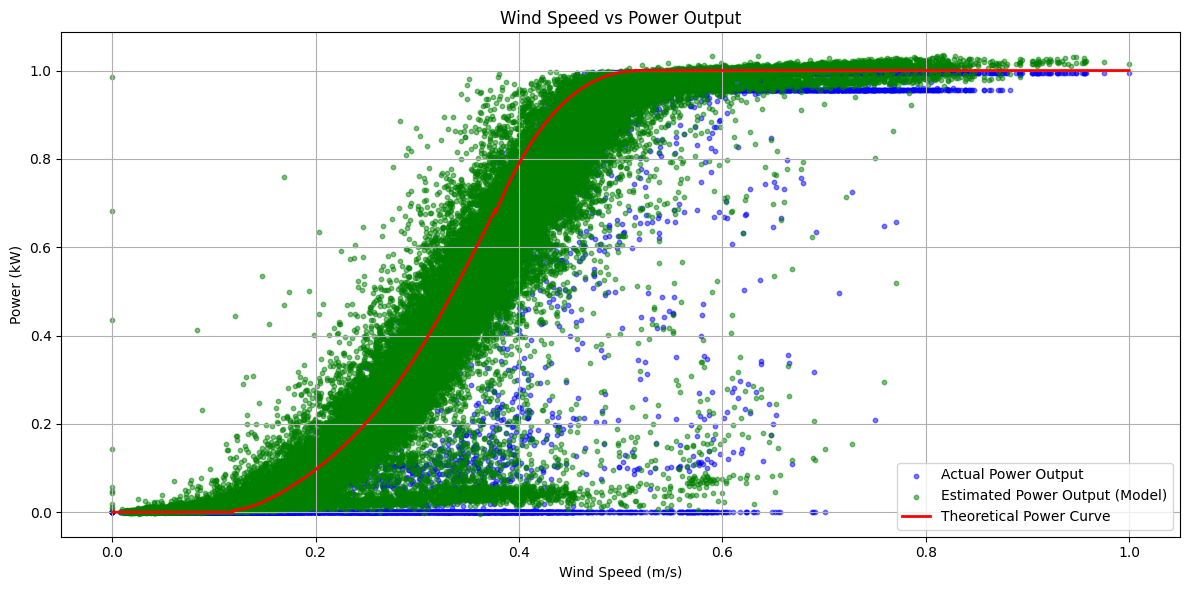

In [20]:
import matplotlib.pyplot as plt

# Step 1: Get model predictions
y_pred = model.predict(X)

# Step 2: Prepare data for plotting
wind_speed = df['Wind Speed (m/s)'].iloc[15:].values  # due to lookback=15
actual_power = df['LV ActivePower (kW)'].iloc[15:].values
theoretical_power = df['Theoretical_Power_Curve (KWh)'].iloc[15:].values

# Step 3: Plotting
plt.figure(figsize=(12, 6))

# Scatter: Actual turbine power vs wind speed
plt.scatter(wind_speed, actual_power, label='Actual Power Output', alpha=0.5, s=10, color='blue')

# Scatter: Model Predicted Power
plt.scatter(wind_speed, y_pred.flatten(), label='Estimated Power Output (Model)', alpha=0.5, s=10, color='green')

# Line: Theoretical power curve
sorted_indices = wind_speed.argsort()
plt.plot(
    wind_speed[sorted_indices],
    theoretical_power[sorted_indices],
    label='Theoretical Power Curve',
    color='red',
    linewidth=2
)

plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
plt.title('Wind Speed vs Power Output')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


1577/1577 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


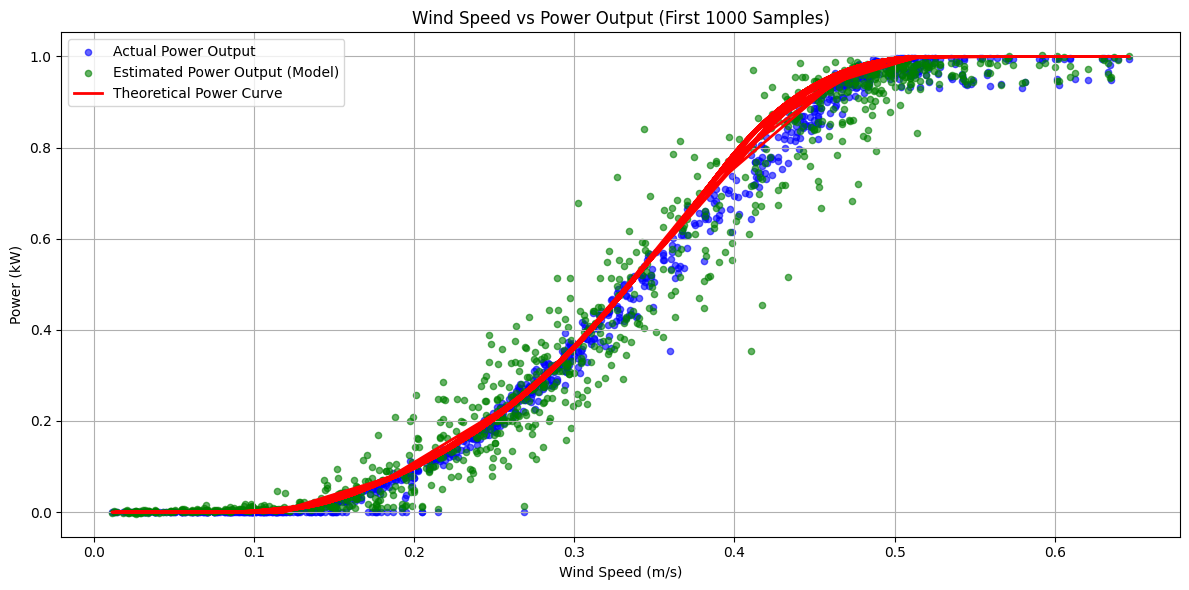

In [24]:
import matplotlib.pyplot as plt

# Step 1: Predict
y_pred = model.predict(X)

# Step 2: Slice first 100 values
n = 1000
wind_speed = df['Wind Speed (m/s)'].iloc[15:15+n].values
actual_power = df['LV ActivePower (kW)'].iloc[15:15+n].values
theoretical_power = df['Theoretical_Power_Curve (KWh)'].iloc[15:15+n].values
predicted_power = y_pred[:n].flatten()

# Step 3: Plot
plt.figure(figsize=(12, 6))

plt.scatter(wind_speed, actual_power, label='Actual Power Output', alpha=0.6, s=20, color='blue')
plt.scatter(wind_speed, predicted_power, label='Estimated Power Output (Model)', alpha=0.6, s=20, color='green')
plt.plot(wind_speed, theoretical_power, label='Theoretical Power Curve', color='red', linewidth=2)

plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
plt.title('Wind Speed vs Power Output (First 1000 Samples)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
# 1 Bilstm 1 64
# Step 7: Evaluate the Model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model training completed.")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

474/474 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Model training completed.
Mean Squared Error (MSE): 0.00460784025093553
Mean Absolute Error (MAE): 0.03889276673496061
R² Score: 0.9650376118966199


In [17]:
model.save("my_bi_lstm_model.h5")


In [18]:
from google.colab import files
files.download("my_bi_lstm_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>